In [ ]:
import pandas as pd
import numpy as np
'''h'''

In [ ]:
trip_data_7_24= pd.read_csv('C:/Python/pythonfall24/202407-bluebikes-tripdata.csv')
stations = pd.read_csv("C:/Python/pythonfall24/current_bluebikes_stations.csv", header =1)

In [ ]:
trip_data_7_24

In [ ]:
stations

In [ ]:
''' 
station starts at max capacity -- number of total docks

each time a station is interacted with, retrieve last interaction w station, then:
    subtract 1 each time trip leaves from station 
    add 1 each time trip ends at station 

for each interaction with station, add to column in row current count of bikes in station after interaction has occured

'''

In [ ]:
'''replace NAs'''
def clean_nas(stations, fillVal):
    naIndices = stations.index[stations['Total Docks'].isna()].tolist()
    for ii in naIndices:
        stations['Total Docks'][ii] = fillVal
    return stations

In [ ]:
'''returns dictionary with info on each station in the dataset, the average total docks per station, and the values that each station should be updated to if their capacity leaves the reasonable range'''
def make_station_info_dict(trip_data, station_data1):
    
    averageCap = 15 ###the mean and median of total dock space is 17 but this is round
    fullAdjustment = 9*(averageCap/11)  ####i've decided im going to try to subtract this from the total and vv
    emptyAdjustment = 9*(averageCap/11)
    
    station_data = clean_nas(station_data1, fillVal = averageCap)
    
    ##makes dictionary of station info based on info present in stations data file
    stationInfo = {stations['NAME'][ii]: {'Total Capacity': int(stations['Total Docks'][ii])} for ii in range(len(stations))}
   

    for station in list(stationInfo): ##originally this was calculated after the dictionary was made
            if (station in set(trip_data['start_station_name'])): #|(station in set(trip_data['end_station_name'])
                #catching stations that don't actually occur in data
                stationInfo[station]['Full Adjustment'] = 9*(stationInfo[station]['Total Capacity'])/11
                stationInfo[station]['Empty Adjustment'] =  9*(stationInfo[station]['Total Capacity'])/11
                stationInfo[station]['Current Capacity'] = 4*(stationInfo[station]['Total Capacity']/7) ## this makes the total amount of bikes in the system at start just under 5000
                stationInfo[station]['Times Empty'] = 0
                stationInfo[station]['Times Full'] =  0
                stationInfo[station]['Total Rides'] = 0
                stationInfo[station]['Member Rides'] = 0
                stationInfo[station]['Electric Bike IN'] = 0
                stationInfo[station]['Electric Bike OUT'] = 0
                stationInfo[station]['Electric Bike and Member Rides'] = 0
            else:
                del stationInfo[station]

        ##adds stations in trip_data that are not in station_data
    for station in (trip_data['start_station_name']):
        if station not in stationInfo:
            stationInfo[station] = create_station_entry(station, averageCap, fullAdjustment, emptyAdjustment)
    for station in (trip_data['end_station_name']):
        if station not in stationInfo:
            stationInfo[station] = create_station_entry(station, averageCap, fullAdjustment, emptyAdjustment)

    #print(f' starting cap: {sum([stationInfo[station]["Current Capacity"] for station in stationInfo])}')
    return stationInfo, averageCap, fullAdjustment, emptyAdjustment

In [ ]:
'''takes in all columns of dataset, returns dataset with additional column of  bikes at each station after trip -- returns updated dataset (and station info dictionary for testing)'''

def calc_bike_count(trip_data, stations):
    stationInfo, averageCap, fullAdjustment, emptyAdjustment = make_station_info_dict(trip_data, stations)

    for ii in range(0, len(trip_data)): #iterate through rows (each trip) in dataset
        row = trip_data.iloc[ii]
        start_station = row['start_station_name']
        end_station = row['end_station_name']
        
        if row['rideable_type'] == 'electric_bike':
            stationInfo[end_station]['Electric Bike IN'] += 1
            stationInfo[start_station]['Electric Bike OUT'] += 1
            if row['member_casual'] == 'member':    
                stationInfo[start_station]['Electric Bike and Member Rides'] += 1 ##this is just start station for now
        if row['member_casual'] == 'member':
            stationInfo[start_station]['Member Rides'] += 1
        
        stationInfo[start_station]['Total Rides'] += 1
        stationInfo[start_station]['Current Capacity'] -=1  
        stationInfo[end_station]['Current Capacity'] += 1
            
        if stationInfo[start_station]['Current Capacity'] < 0: ### adjust to be within correct bounds
            stationInfo[start_station]['Current Capacity'] = stationInfo[start_station]["Empty Adjustment"] 
            stationInfo[start_station]['Times Empty'] += 1

        if stationInfo[end_station]['Current Capacity'] > stationInfo[end_station]['Total Capacity']:
            stationInfo[end_station]['Current Capacity'] = (stationInfo[start_station]["Total Capacity"] - stationInfo[end_station]['Full Adjustment'])
            stationInfo[end_station]['Times Full'] += 1
    
        trip_data.at[ii, 'start_station_capacity'] =  stationInfo[start_station]['Current Capacity'] ## add to trip data
        trip_data.at[ii, 'end_station_capacity'] = stationInfo[end_station]['Current Capacity']

    return trip_data, stationInfo

In [ ]:
def create_station_entry(station, averageCap, fullAdjustment, emptyAdjustment): ## this is still being called in the function above for some entries
 ### creates station dictionary entry with average stats
        return{'Total Capacity': averageCap, 'Current Capacity': 9, 'Full Adjustment': fullAdjustment, 'Empty Adjustment': emptyAdjustment, 'Times Empty': 0, 'Times Full': 0, 'Total Rides': 0, 'Member Rides': 0, 'Electric Bike IN':0, 'Electric Bike OUT': 0, 'Electric Bike and Member Rides': 0}

In [ ]:
###normalize bike count --> if trip will reduce to 0 count, return to full capacity? this feels wrong
## but not sure how to understand this metric as is


##how often go from 0 to -1 (this means at least one bike must be added)

##OR restrict capacity count to reasonable range --- 0 and dock space per station

## according to bluebikes media kit: by 2023, there were over 4000 bikes in the system
### then, in the end of 2023, they added 750 electric bikes ---> there should only be ~5000 bikes in total at all stations at any given time

##TESTING vvv

In [ ]:
trip_data, stations1 = calc_bike_count(trip_data_7_24, stations)

In [ ]:
#testing
print('total total capacity: ', sum([stations1[station]['Total Capacity'] for station in stations1]))
print('total current capacity: ', sum([stations1[station]['Current Capacity'] for station in stations1]))
for station in stations1:
    print(F"{station}, member: {stations1[station]['Member Rides']}, both: {stations1[station]['Electric Bike and Member Rides']}")
    from statistics import median
from statistics import mean
print(median(stations['Total Docks']))
print(mean(stations['Total Docks']))

In [ ]:
## creating lists of the capacity of station after each ride, and the date/time of each ride, to graph
cap_list = []
date_time_list = []
for ii in range(0, len(trip_data)):
    if (trip_data.at[ii, 'start_station_name']== 'Kendall T'):
        cap_list.append(trip_data.at[ii, 'start_station_capacity'])
        date_time_list.append(trip_data.at[ii, 'started_at'])
    elif (trip_data.at[ii, 'end_station_name']== 'Kendall T'):
        cap_list.append(trip_data.at[ii, 'end_station_capacity'])
        date_time_list.append(trip_data.at[ii, 'started_at'])

In [ ]:
from plotnine import (ggplot,
                      aes,
                      labs, geom_jitter, theme, element_text, geom_point, scale_color_brewer, geom_line,
                      geom_bin_2d, geom_hline)

In [ ]:
from matplotlib import pyplot
import numpy as np

In [ ]:
print(cap_list[0:100])

In [ ]:
plot1 =( (ggplot(aes(x = date_time_list[0:100], y = cap_list[0:100])) + geom_line(group = 1, color = '#8A2BE2') + geom_hline(yintercept = [0, stations1['Kendall T']['Total Capacity']], color = '#006400') + geom_hline(yintercept = [(stations1['Kendall T']["Total Capacity"]-stations1['Kendall T']['Full Adjustment']), stations1['Kendall T']['Empty Adjustment']], linetype = 'dashed') + labs(x = 'Ride', y = 'Capacity', title = 'Capacity of Kendall T Dock (first 100 rides in July 2024)') + theme(axis_text_x = element_text(angle = 80, va = 'top', ha = 'right', rotation_mode = 'anchor'))).draw() )

In [ ]:
xPlt = np.array([date_time_list[0:100]]) #list(range(0, len(date_time_list[0:100])))
yPlt = np.array([cap_list[0:100]])

pyplot.scatter(xPlt, yPlt)
pyplot.show()

In [ ]:
plot2 = (ggplot(aes(x = date_time_list[-100:-1], y = cap_list[-100:-1])) + geom_line(group = 1) +
 labs(x = 'Ride #', y = 'Capacity', title = 'Capacity of Kendall T (latest 100 days)') + theme(axis_text_x = element_text(angle = 80, va = 'top', ha = 'right', rotation_mode = 'anchor'))).draw()

In [ ]:
ax = plot1.axes[0]
xticks1 = ax.xaxis.get_major_ticks()
for i, tick in enumerate(xticks1):
    if i % 5 != 0:
        tick.label1.set_visible(False)
    else:
        tick = str(i)

In [ ]:
plot1.xticks(ticks = list(range(0, 100)), labels = list(range(1,101)))

In [ ]:
plot1

In [ ]:

plt1
#plot1

In [ ]:
ax = plot2.axes[0]
xticks2 = ax.xaxis.get_major_ticks()
for i, tick in enumerate(xticks2):
    if i % 5 != 0:
        tick.label1.set_visible(False)

In [ ]:
plot2.savefig('plot2')
plot2

In [ ]:
# features
def add_feats(trip_data, stations):
    stationCounts = trip_data['start_station_name'].value_counts()
    
    for station in set(trip_data['start_station_name']):
        
            ##total number of rides out of station
            
           ## print(stations['NAME'].loc['Centre St at Allandale St'])
           # break
            #print(stations[station])
            #print(stationCounts[station])
        stations[station]['Total Rides'] = stationCounts[station]
            ## average # of bikes available ---  sum of current capacity/total rides
            ## frequency empty
            ## frequency full
            ## proportion of rides w/ electric bikes -- # electric rides/total rides
    return stations

In [ ]:
#print(set(trip_data['start_station_name']))
#(set(stations1))
print(list(stations1.keys())[-10])
print(stations1['nan'])

In [ ]:
print(len(set(trip_data['start_station_name'])))
print(len(set(stations1)))

In [ ]:
c = []
for val in set(stations1):

    # Check if the current value is not in list 'b'
    if val not in set(trip_data['start_station_name']):

        # If it's not in 'b', append it to list 'c'
        c.append(val)

print(c)

In [ ]:
print(stations1['nan'])

In [ ]:
print(add_feats(trip_data, stations1))

In [ ]:
### make dataframe with features for model
feats = pd.DataFrame.from_dict(stations1, orient = 'index')
feats = feats.drop('Total Rides', axis = 1)
feats = feats.drop('Member Rides', axis = 1)
feats = feats.drop('Electric Bike and Member Rides', axis = 1)
feats = feats.drop('Full Adjustment', axis = 1)
feats = feats.drop('Empty Adjustment', axis = 1)
feats = feats.drop('Current Capacity', axis = 1)
feats

In [ ]:
labels = []
for station in stations1:
    if (stations1[station]['Total Rides']) == 0:
        label = 0
    else:
        label = (stations1[station]['Member Rides'])/(stations1[station]['Total Rides'])
    labels.append(label)


In [ ]:
for station in feats.index:
    print(station)
    break

In [ ]:
#get proportion of electric rides to regular
# get total rides by station
for station in feats.index:
    trips = trip_data.loc[trip_data['start_station_name'] == station]
    feats.loc[station, 'total trips'] = len(trips) ## total trips at station in month

    electricRides = trips.loc[trips['rideable_type'] == 'electric_bike']
    if len(trips) == 0:
        propElectric = 0

    else:
        propElectric = len(electricRides)/len(trips)
    
    feats.loc[station, 'propElectric'] = propElectric




In [ ]:
feats = feats.drop('Electric Bike IN', axis = 1)
feats = feats.drop('Electric Bike OUT', axis = 1)

In [ ]:
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(feats, labels, test_size=0.20)

linearReg = LinearRegression()
linearReg.fit(X_train, y_train)
linearReg.score(X_test, y_test)

In [64]:
linearReg.feature_names_in_

array(['Total Capacity', 'Times Empty', 'Times Full', 'total trips',
       'propElectric'], dtype=object)

In [65]:
linearReg.coef_

array([ 0.01288683,  0.00357464, -0.00034351, -0.0001788 , -0.04992968])

In [ ]:
preds = linearReg.predict(X_test)
preds

In [ ]:
predPlot =( (ggplot(aes(x = date_time_list[0:100], y = cap_list[0:100])) + geom_line(group = 1, color = '#8A2BE2') + geom_hline(yintercept = [0, stations1['Kendall T']['Total Capacity']], color = '#006400') + geom_hline(yintercept = [(stations1['Kendall T']["Total Capacity"]-stations1['Kendall T']['Full Adjustment']), stations1['Kendall T']['Empty Adjustment']], linetype = 'dashed') + labs(x = 'Ride', y = 'Capacity', title = 'Capacity of Kendall T Dock (first 100 rides in July 2024)') + theme(axis_text_x = element_text(angle = 80, va = 'top', ha = 'right', rotation_mode = 'anchor'))).draw() )

In [ ]:
from matplotlib import pyplot as plt
import matplotlib

In [ ]:
stations_plot = feats.index.astype(str)

AttributeError: 'PathCollection' object has no attribute 'scatter'

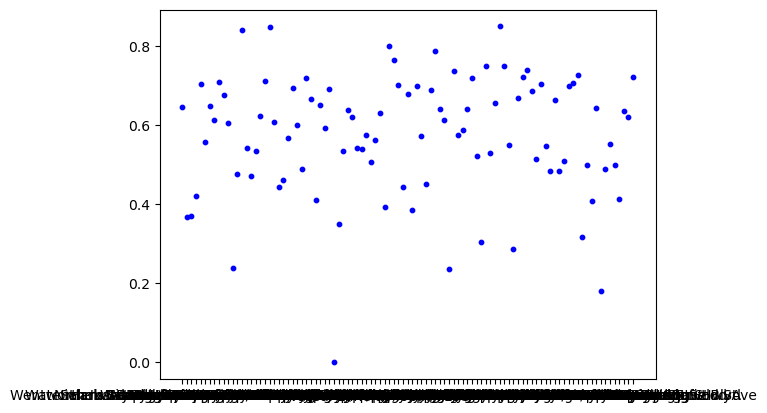

In [54]:
p = plt.figure()
ax1 = plt.subplot(111)
ax1 = ax1.scatter(X_test.index, y_test, label = 'actual', marker = 'o', color = 'b', s = 10)
ax1 = ax1.scatter(X_test.index, preds_plot, label = 'predicted', marker = 's', color = 'r', s = 10)
p = plt.legend()
p = plt.grid(True)
p = plt.show()

C:\Users\aliky\AppData\Local\Temp\ipykernel_13344\2827748048.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


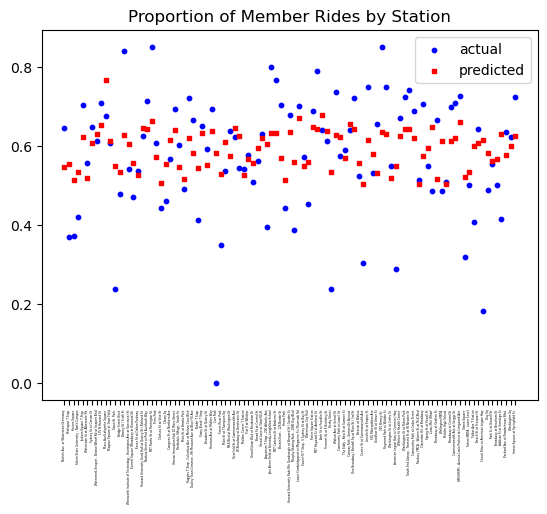

In [63]:
#matplotlib.use('TkAgg')
%matplotlib inline
ax2 = plt.subplot(111)
ax2.scatter(X_test.index, y_test, label = 'actual', marker = 'o', color = 'b', s = 10)
ax2.scatter(X_test.index, preds, label = 'predicted', marker = 's', color = 'r', s = 10)
plt.title("Proportion of Member Rides by Station")
plt.xticks(rotation=90, fontsize = 2)
plt.legend()
ax2.figure.show()